In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

import keras 
from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from nltk.tokenize import word_tokenize
import numpy as np

In [2]:
from google.colab import drive,files
drive.mount("/content/drive")
dataM='/content/drive/My Drive/Colab Notebooks/MODELS/'
filepath = dataM+'BERT_CRF.ml'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
!pip install tf2crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from tf2crf import CRF 
from tf2crf import ModelWithCRFLoss

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [7]:
XTr=['Google wants a backend developer with good coding skills','There is a position open for machine learning engineer, Meta is looking for people with machine learning background']
XVal=['Amazon is looking for DevOps engineer']
org_b={'google':'C','amazon':'C','meta':'C','microsoft':'C','qualcomm':'C'}
skills_b={'coding':'S','machine':'S','learning':'S'}
jobs_b={'backend':'J','developer':'J','engineer':'J','manager':'J','devops':'J'}

def make(X,org_b,skills_b,jobs_b):
  big=[]
  for sentence in X:
    token=word_tokenize(sentence)
    small=[]
    token_t=nltk.pos_tag(token)
    for f,s in token_t:
      tag='O'
      if f.lower() in org_b:
        tag=org_b[f.lower()]
      if f.lower() in skills_b:
        tag=skills_b[f.lower()]
      if f.lower() in jobs_b:
        tag=jobs_b[f.lower()]
      small.append((f,s,tag))
    big.append(small)
  return big
  
XTr_=make(XTr,org_b,skills_b,jobs_b)
XVal_=make(XVal,org_b,skills_b,jobs_b)

In [8]:
msgLen=128

def fixMsg(X):
  global msgLen
  Xc=[]
  for i in range(len(X)):
    if len(X[i])<msgLen:
      while len(X[i])<msgLen:
        X[i].append(('UNK','UNK','UNK'))
    elif len(X[i])>msgLen:
      temp=X[i]
      del X[i]
      lb=0;chunk=msgLen
      while lb<len(temp):
        split=[]
        for j in range(lb,lb+chunk):
          if j<len(temp):
            split.append(temp[j])
          else:
            split.append(('UNK','UNK','UNK'))
        X.append(split)
        print(X)
        lb+=chunk
  return X 

XTr_t=fixMsg(XTr_)
XVal_t=fixMsg(XVal_)

In [9]:
dict_={}
dict_1={}
token=1;token1=0
for x in XTr_t:
  for a,b,c in x:
    if a not in dict_:
      dict_[a]=token
      token=token+1
    if c not in dict_1:
      if c=='K':
        print(a,b,c)
      dict_1[c]=token1
      token1=token1+1
for x in XVal_t:
  for a,b,c in x:
    if a not in dict_:
      dict_[a]=token
      token=token+1
    if c not in dict_1:
      dict_1[c]=token1
      token1=token1+1
print('No of tokens words[{}] labels[{}]'.format(token,token1))

No of tokens words[26] labels[5]


In [10]:
XTr_fin=np.array(XTr)
XVal_fin=np.array(XVal)

yTr=np.array([[dict_1[element[2]] for element in sentence] for sentence in XTr_t])
yVal=np.array([[dict_1[element[2]] for element in sentence] for sentence in XVal_t])

In [11]:
import tensorflow_text as text
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3")

In [12]:
text_preprocessed = preprocessor(XTr_fin)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (2, 128)
Word Ids   : [  101  7986  3349   170  1171  6696  9991  1114  1363 19350  4196   102]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
# https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4
# https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4', trainable=False)

In [16]:
input=Input(shape=(), dtype=tf.string)
model0=preprocessor(input)
seq_op=bert_layer(model0)['sequence_output']
model0=Model(input,seq_op)
model0.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_2[0][0]']                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [17]:
XTr_fin=model0.predict(XTr_fin)
XVal_fin=model0.predict(XVal_fin)

1/1 [==============================] - 0s 430ms/step


In [18]:
print(XTr_fin.shape,XVal_fin.shape,type(XTr_fin),type(XVal_fin))

(2, 128, 768) (1, 128, 768) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [19]:
print(yTr.shape,yVal.shape,type(yTr),type(yVal))

(2, 128) (1, 128) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [20]:
input=Input(shape=(XTr_fin.shape[1],XTr_fin.shape[2]))
output=CRF(units=token1)(input)
mo=Model(input,output)
mo.summary()

model1=ModelWithCRFLoss(mo,sparse_target=True)
model1.compile(optimizer ='rmsprop')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 768)]        0         
                                                                 
 crf (CRF)                   ((None, 128),             3870      
                              (None, 128, 5),                    
                              (None,),                           
                              (5, 5))                            
                                                                 
Total params: 3,870
Trainable params: 3,870
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model1.fit(np.array(XTr_fin),np.array(yTr),epochs=10,validation_data=[XVal_fin,yVal],batch_size=1)

Epoch 1/10
2/2 [==============================] - 4s 734ms/step - loss: 230.6958 - accuracy: 0.1914 - val_loss_val: 214.6125 - val_val_accuracy: 0.0625
Epoch 2/10
2/2 [==============================] - 0s 59ms/step - loss: 157.0932 - accuracy: 0.5195 - val_loss_val: 169.7881 - val_val_accuracy: 0.4688
Epoch 3/10
2/2 [==============================] - 0s 56ms/step - loss: 121.4556 - accuracy: 0.7305 - val_loss_val: 140.6268 - val_val_accuracy: 0.5625
Epoch 4/10
2/2 [==============================] - 0s 54ms/step - loss: 99.5757 - accuracy: 0.8438 - val_loss_val: 119.9150 - val_val_accuracy: 0.7734
Epoch 5/10
2/2 [==============================] - 0s 72ms/step - loss: 84.8689 - accuracy: 0.8867 - val_loss_val: 104.6001 - val_val_accuracy: 0.9141
Epoch 6/10
2/2 [==============================] - 0s 60ms/step - loss: 74.3587 - accuracy: 0.9023 - val_loss_val: 92.8030 - val_val_accuracy: 0.9297
Epoch 7/10
2/2 [==============================] - 0s 63ms/step - loss: 66.4476 - accuracy: 0.9023

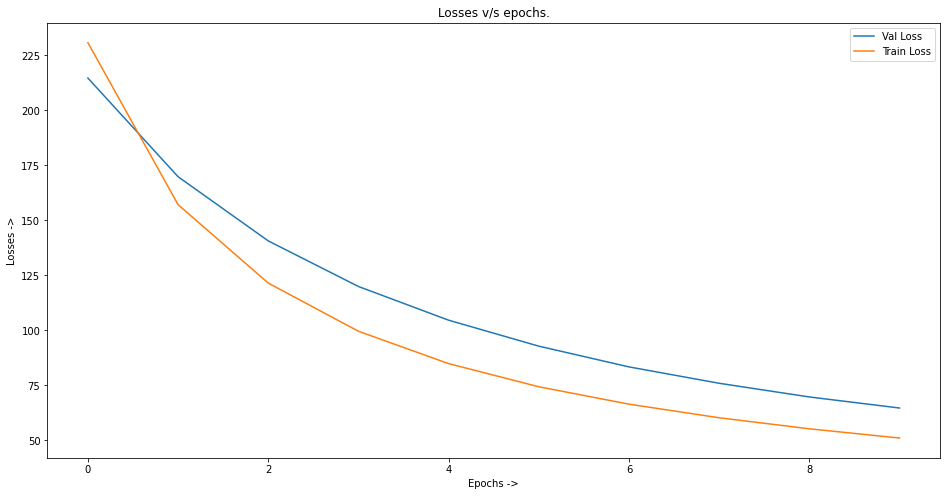

In [22]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(history.history['val_loss_val'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs ->')
plt.ylabel('Losses ->')
plt.title('Losses v/s epochs.')
plt.legend(['Val Loss','Train Loss'])
plt.show()

In [23]:
dict_1R={}
for k,v in dict_1.items():
  dict_1R[v]=k

In [24]:
labels_=model1.predict(XVal_fin)
i=0 # i-th example from val dataset.
cnt=0
print()
for x in XVal_[0]:
  print('{} {}'.format(x[0],dict_1R[labels_[i][cnt]]))
  cnt+=1
  if cnt>10:
    break

1/1 [==============================] - 0s 294ms/step

Amazon UNK
is UNK
looking O
for O
DevOps O
engineer UNK
UNK O
UNK UNK
UNK UNK
UNK UNK
UNK UNK


In [25]:
dict_1

{'C': 0, 'O': 1, 'J': 2, 'S': 3, 'UNK': 4}

In [26]:
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

def labelIt(yVal):
  yVal_lis=[]
  for y1 in yVal:
    temp=[]
    for y2 in y1:
      temp.append(dict_1R[y2])
    yVal_lis.append(temp)
  return yVal_lis 

yVal_=labelIt(yVal)
yPred_=labelIt(labels_)
labls=['C','J','S','O','UNK']
metrics.flat_f1_score(yVal_,yPred_,average='weighted',labels=labls)

0.94140625

In [28]:
pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
print(metrics.flat_classification_report(yVal_,yPred_,labels=labls,digits=3))

              precision    recall  f1-score   support

           C      0.000     0.000     0.000         1
           J      0.000     0.000     0.000         2
           S      0.000     0.000     0.000         0
           O      0.400     0.667     0.500         3
         UNK      0.975     0.975     0.975       122

    accuracy                          0.945       128
   macro avg      0.275     0.328     0.295       128
weighted avg      0.939     0.945     0.941       128



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['C', 'J', 'S', 'O', 'UNK'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
